In [3]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from tensorflow.keras.models import load_model

In [2]:
# Check if GPU is available and set TensorFlow to use GPU if available
if tf.config.list_physical_devices('GPU'):
    print('GPU is available.')
else:
    print('No GPU available, using the CPU instead.')

GPU is available.


## Data Preprocessing

In [3]:
# Create an instance of ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,      # Rotate images by random angle within the specified range
    width_shift_range=0.2,  # Shift images horizontally by a fraction of total width
    height_shift_range=0.2, # Shift images vertically by a fraction of total height
    horizontal_flip=True,   # Flip images horizontally
    vertical_flip=True,     # Flip images vertically
    zoom_range=0.2,         # Randomly zoom images
    shear_range=0.2,        # Apply shear transformation
    fill_mode='nearest'     # Fill mode for newly created pixels
)

# Apply data augmentation to all images
all_images = []
all_labels = []

# Classes
class_number = ["1", "2", "3", "4", "5"]

# Loop through each class directory and augment images
for class_num in class_number:
    class_dir = os.path.join('/kaggle/input/Fruits_Dataset/train', class_num)
    
    # Loop through each image in the class directory
    for filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, filename)
        img = load_img(img_path, target_size=(128, 128))
        image = img_to_array(img)
        image = image / 255.0
        
        # Apply data augmentation to the image
        augmented_image_gen = datagen.flow(np.expand_dims(image, axis=0), batch_size=1)
        augmented_image1 = augmented_image_gen.next()[0]
        augmented_image2 = augmented_image_gen.next()[0]
        
        # Append original image and labels to lists
        all_images.append(image)
        all_labels.append(int(class_num))
        
        # Append augmented images and labels to lists
        all_images.append(augmented_image1)
        all_labels.append(int(class_num))
        all_images.append(augmented_image2)
        all_labels.append(int(class_num))


In [4]:
# Convert lists to numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Create a DataFrame
dataset = pd.DataFrame({'Image': list(all_images), 'Label': all_labels})

In [5]:
len(dataset)

29700

In [6]:
# Split the augmented data into train, validation, and test sets
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42, shuffle=True)
#train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.125, random_state=42, shuffle=True)

# Separate data and labels for train, validation, and test sets
x_train = np.array(train_dataset['Image'].tolist())
y_train = np.array(train_dataset['Label'])

#x_val = np.array(val_dataset['Image'].tolist())
#y_val = np.array(val_dataset['Label'])

x_test = np.array(test_dataset['Image'].tolist())
y_test = np.array(test_dataset['Label'])

In [7]:
# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train - 1, num_classes=5)
#y_val = tf.keras.utils.to_categorical(y_val - 1, num_classes=5)
y_test = tf.keras.utils.to_categorical(y_test - 1, num_classes=5)

# Create TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
#val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

print('train dataset size:', len(train_dataset))
#print('val dataset size:', len(val_dataset))
print('test dataset size:', len(test_dataset))

train dataset size: 743
test dataset size: 186


## Build CNN model

## Train the model

In [8]:
model = Sequential()

model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(256, activation='relu'))

model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 32)        0

In [9]:
# Train the model
#history = model.fit(train_dataset, validation_data=val_dataset, epochs=20)
history = model.fit(train_dataset, epochs=100)

Epoch 1/100


2024-05-21 14:20:50.403298: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


743/743 [==============================] - 13s 12ms/step - loss: 1.4219 - accuracy: 0.3640
Epoch 2/100
743/743 [==============================] - 8s 11ms/step - loss: 1.2299 - accuracy: 0.4605
Epoch 3/100
743/743 [==============================] - 8s 11ms/step - loss: 1.1518 - accuracy: 0.5098
Epoch 4/100
743/743 [==============================] - 8s 11ms/step - loss: 1.1072 - accuracy: 0.5374
Epoch 5/100
743/743 [==============================] - 8s 11ms/step - loss: 1.0665 - accuracy: 0.5622
Epoch 6/100
743/743 [==============================] - 8s 11ms/step - loss: 1.0318 - accuracy: 0.5754
Epoch 7/100
743/743 [==============================] - 8s 11ms/step - loss: 0.9984 - accuracy: 0.5941
Epoch 8/100
743/743 [==============================] - 8s 11ms/step - loss: 0.9747 - accuracy: 0.6049
Epoch 9/100
743/743 [==============================] - 8s 11ms/step - loss: 0.9494 - accuracy: 0.6176
Epoch 10/100
743/743 [==============================] - 8s 11ms/step - loss: 0.9299 - accurac

In [10]:
history

In [11]:
# Print the training and validation accuracy
train_accuracy = history.history['accuracy']
#val_accuracy = history.history['val_accuracy']

for epoch in range(len(train_accuracy)):
    train_accuracy[epoch] = train_accuracy[epoch] * 100
    #val_accuracy[epoch] = val_accuracy[epoch] * 100
    print(f"Epoch {epoch+1} - Training Accuracy: {train_accuracy[epoch]:.2f}")
    #print(f"Epoch {epoch+1} - Validation Accuracy: {val_accuracy[epoch]:.2f}")

Epoch 1 - Training Accuracy: 36.40
Epoch 2 - Training Accuracy: 46.05
Epoch 3 - Training Accuracy: 50.98
Epoch 4 - Training Accuracy: 53.74
Epoch 5 - Training Accuracy: 56.22
Epoch 6 - Training Accuracy: 57.54
Epoch 7 - Training Accuracy: 59.41
Epoch 8 - Training Accuracy: 60.49
Epoch 9 - Training Accuracy: 61.76
Epoch 10 - Training Accuracy: 62.62
Epoch 11 - Training Accuracy: 63.96
Epoch 12 - Training Accuracy: 64.38
Epoch 13 - Training Accuracy: 65.25
Epoch 14 - Training Accuracy: 65.91
Epoch 15 - Training Accuracy: 66.58
Epoch 16 - Training Accuracy: 66.80
Epoch 17 - Training Accuracy: 67.21
Epoch 18 - Training Accuracy: 68.04
Epoch 19 - Training Accuracy: 68.27
Epoch 20 - Training Accuracy: 68.92
Epoch 21 - Training Accuracy: 69.37
Epoch 22 - Training Accuracy: 69.39
Epoch 23 - Training Accuracy: 69.88
Epoch 24 - Training Accuracy: 70.26
Epoch 25 - Training Accuracy: 70.47
Epoch 26 - Training Accuracy: 70.95
Epoch 27 - Training Accuracy: 71.04
Epoch 28 - Training Accuracy: 71.13
E

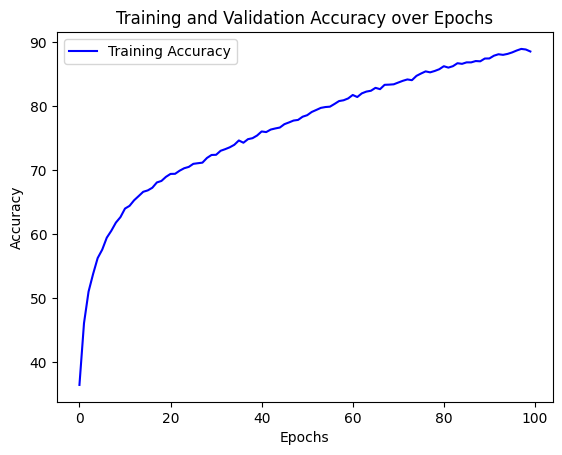

In [12]:
# Plot training and validation Accuracy graph
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
#plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()

## Evaluate the model

In [13]:
# Evaluate the model on the test data
test_history = model.evaluate(test_dataset)

186/186 [==============================] - 2s 6ms/step - loss: 0.9869 - accuracy: 0.6862


In [14]:
test_accuracy = test_history[1] * 100
print(f"Test Accuracy = {test_accuracy:.2f} %")

Test Accuracy = 68.62 %


## Save the model

In [15]:
model.save(os.path.join('models','fruitclassifier.h5'))

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Classify the testing images

In [7]:
# Load the model
new_model = load_model(os.path.join('models', 'fruitclassifier.h5'))

directory_path = r'D:\Gethub\Fruits-Classification-using-Deep-Learning\Fruits_Dataset\test'

# Get a list of all files in the directory
all_images = os.listdir(directory_path)

# Filter the list to include only files with certain extensions
image_names_without_extention = [os.path.splitext(file)[0] for file in all_images if file.lower().endswith(('.jpg', '.png', '.jpeg'))]

# Load and preprocess images
predictions = []
for image_name in all_images:
    image_path = os.path.join(directory_path, image_name)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))  # Resize to match the model input size
    img = img / 255.0  # Normalize pixel values to the range [0, 1]
    preds = new_model(np.expand_dims(img, 0))
    index_of_largest = np.argmax(preds, axis=1)
    pred = index_of_largest + 1
    if pred == 1:
        predictions.append('Apple')
    elif pred == 2:
        predictions.append('Banana')
    elif pred == 3:
        predictions.append('Grapes')
    elif pred == 4:
        predictions.append('Mango')
    elif pred == 5:
        predictions.append('Strawberry')
    
# Convert predictions and image names to a DataFrame
df = pd.DataFrame({'image_id': image_names_without_extention, 'label': predictions})

# Save DataFrame to a CSV file
df.to_csv('predictions.csv', index=False)